# Result Exploration
This notebook helps to build functions for printing results of CNN training.

In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from Scripts import Print_Functions as PF
from Scripts import Centralized_CNN as cNN

FIGURES = os.path.join(module_path, "Figures")

In [45]:
# Set Parameters
params = PF.PlotParams(
            dataset='Pain',
            experiment='Centralized',
            metric='F1_Score',
            legend_loc='lower right',
            num_format="{:5.1%}",
            max_epochs=None,
            label_spaces=1
)

In [3]:
def aggregate_df(df, cols):
    return df[cols].drop_duplicates().reset_index(drop=True)

In [4]:
def make_pain_plot(folder, params, final_epoch=29, agg_cols=None):
    files = os.listdir(folder)
    files = [os.path.join(folder, file) for file in files if file.endswith('{}.csv'.format(final_epoch))]
    files = sorted(files)

    legend = []
    for idx, file in enumerate(files):
        df = pd.read_csv(file)
        if agg_cols is not None:
            df = aggregate_df(df, agg_cols)
        
        plt.plot(df[params.metric], color=params.colors[idx + 1])
        for i, j in df[params.metric][:params.max_epochs].items():
            if not int(i) % params.label_spaces:
                plt.text(i, j, params.num_format.format(j), color='black',
                         bbox=dict(facecolor='white', edgecolor=params.colors[idx + 1], boxstyle='round'))

        legend.append('Group 1 + {0:.0%}% Group 2'.format(0.1 * idx))

    plt.legend(legend, loc=params.legend_loc)
    plt.title('{} | {} | Group 1 + X% Group 2'.format(params.metric, params.experiment))
    plt.yticks(np.arange(0.3, 1.05, step=0.05))
    plt.ylabel('{}'.format(params.metric))
    plt.xticks(np.arange(0, i+1, step=1))
    plt.xlabel('Epochs / Communication Rounds')
    return plt

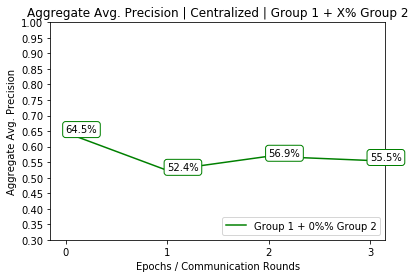

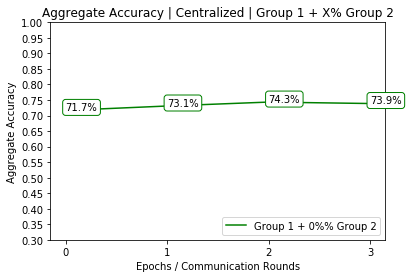

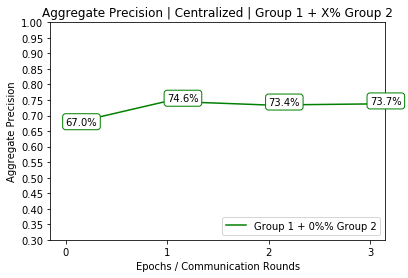

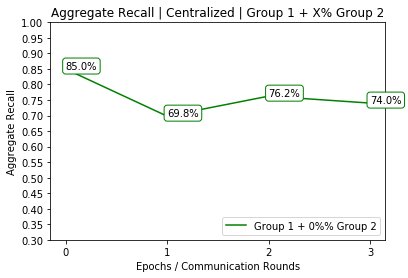

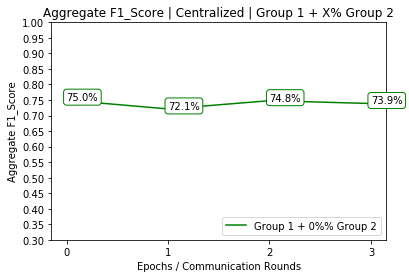

In [5]:
# Prepare Aggregate Plots
path = "/Users/nico/PycharmProjects/FederatedLearning/Results/"
aggregate_cols = ['Epoch', 'Loss', 'Aggregate Avg. Precision', 'Aggregate Accuracy', 
                  'Aggregate Precision', 'Aggregate Recall', 'Aggregate F1_Score']
metrics = ['Aggregate Avg. Precision', 'Aggregate Accuracy', 'Aggregate Precision', 'Aggregate Recall', 'Aggregate F1_Score']
for metric in metrics:
    params.metric = metric
    plt = make_pain_plot(path, params, "l", aggregate_cols)
    plt.show()

In [29]:
# Prepare dataframe for plotting
df = pd.read_csv('/Users/nico/PycharmProjects/FederatedLearning/Results/logs_individual.csv', index_col=0)
df['Person'] = df['Person'].astype(int)
df.pivot(index='Epoch', columns='Person', values='Individual Accuracy').plot()

AttributeError: 'Line2D' object has no property 'ylabel'

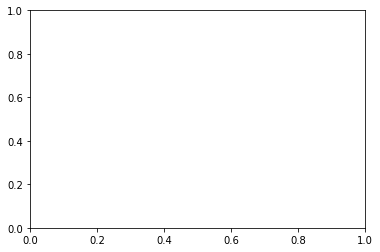

In [49]:
metrics = ['Individual Avg. Precision', 'Individual Accuracy', 'Individual Precision', 'Individual Recall', 'Individual F1-Score']
for metric in metrics:
    params.metric = metric
    plt = df.pivot(index='Epoch', columns='Person', values=metric).plot(
        title='{} | {} | Group 1 + X% Group 2'.format(params.metric, params.experiment),
        yticks=np.arange(0.3, 1.05, step=0.05),
        ylabel='{}'.format(params.metric),
        xticks=np.arange(0, 3+1, step=1),
        xlabel='Epochs / Communication Rounds'
    )